In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Task 1: maximum likelihood fit (3 points)

Let's generate a Gaussian mixture dataset and then fit its parameters with maximum likelihood.

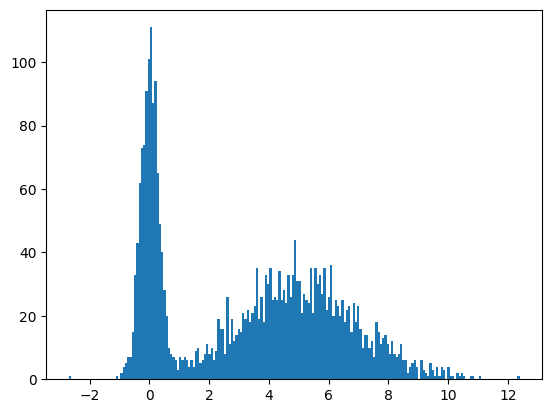

In [2]:
X1 = np.random.normal(size=1000, scale=0.3).astype('float32')
X2 = np.random.normal(size=2000, loc=5., scale=2.).astype('float32')

X = np.concatenate([X1, X2])
np.random.shuffle(X)

plt.hist(X, bins=200);

**Task**:
 - fill the gaps below to perform the max. likelihood fit with the pdf:
$$\text{PDF}(x|\mu_1, \sigma^2_1, \mu_2, \sigma^2_2, \alpha)
= \alpha\cdot\mathscr{N}(x|\mu_1, \sigma_1^2) + (1 - \alpha)\cdot\mathscr{N}(x|\mu_2, \sigma_2^2)$$
 - what the fitted values of $\mu_1, \sigma^2_1, \mu_2, \sigma^2_2$ and $\alpha$ should be? does your fit converge to them?

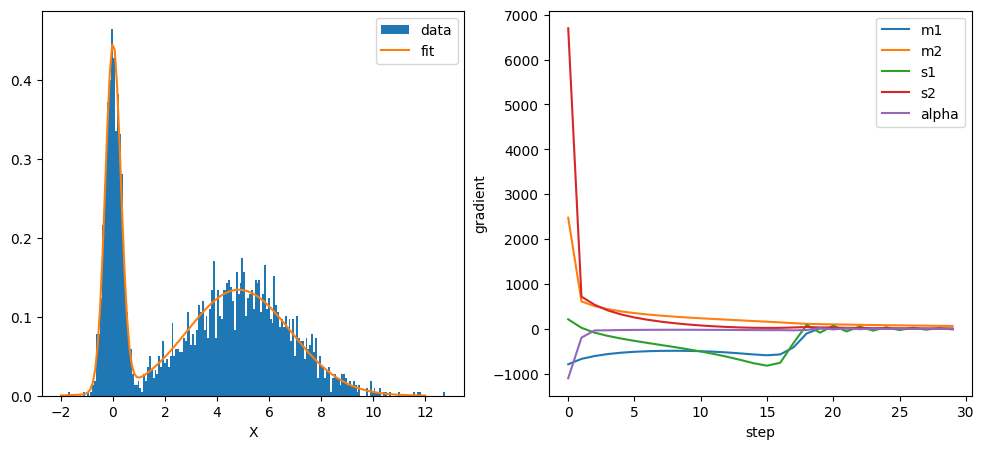

In [17]:
from IPython.display import clear_output

def gaussian(x, mu, sigma):
    # The normalization constant for the Gaussian distribution
    normalization = 1 / (sigma * torch.sqrt(torch.tensor(2 * np.pi)))
    # The exponent
    exponent = -0.5 * ((x - mu) / sigma) ** 2
    return normalization * torch.exp(exponent)

# Arbitrary mixture PDF
def mixture(x, f1, f2, alpha):
  return alpha * f1(x) + (1. - alpha) * f2(x)

# Parameters that we'd like to infer (with an initial guess)
m1 = torch.tensor([1.0], requires_grad=True)
m2 = torch.tensor([4.0], requires_grad=True)
s1 = torch.tensor([1.0], requires_grad=True)
s2 = torch.tensor([1.0], requires_grad=True)
alpha = torch.tensor([0.5], requires_grad=True)


def apply_constraints():
    s1.data.clamp_(1e-5)  # Ensure s1 is positive
    s2.data.clamp_(1e-5)  # Ensure s2 is positive
    alpha.data.clamp_(0.0, 1.0)  # Ensure alpha is between 0 and 1


variables = [m1, m2, s1, s2, alpha]


def model_pdf(x):
  return mixture(x,
                 lambda t: gaussian(t, m1, s1),
                 lambda t: gaussian(t, m2, s2),
                 alpha)

def loglike(x):

    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x).float()

    log_probs = torch.log(model_pdf(x))
    return torch.sum(log_probs)


learning_rate = 0.0001
grad_history = [] # to keep track of gradient values at different steps

# Convert X to a tensor if it's not already one
X_tensor = torch.tensor(X, dtype=torch.float32) if isinstance(X, np.ndarray) else X

for i in range(30):
    # Forward pass:
    l = loglike(X_tensor)

    # Zero the gradients before backward pass
    for var in variables:
        if var.grad is not None:
            var.grad.zero_()

    # Backprop
    l.backward()  # Compute gradients

    # Gradient ascent step
    with torch.no_grad():
        for var in variables:
            var += learning_rate * var.grad

    apply_constraints()

    # Track the gradient history
    grad_history.append([v.grad.item() for v in variables])

    # Do some plotting
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(X, bins=200, density=True, label='data')
    x_grid = np.linspace(-2, 12, 150)
    plt.plot(x_grid, model_pdf(torch.tensor(x_grid)).detach().numpy(), label='fit')
    plt.legend()
    plt.xlabel('X')

    plt.subplot(1, 2, 2)
    lines = plt.plot(np.array(grad_history))
    plt.legend(lines, ['m1', 'm2', 's1', 's2', 'alpha'])
    plt.xlabel('step')
    plt.ylabel('gradient')
    plt.show()
    clear_output(wait=True)


# Task 2: classifying clothes (3 points)

In [11]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))
                               ])

# Download and load the training data
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)

100%|██████████| 26421880/26421880 [00:01<00:00, 16818654.93it/s]


Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 302788.02it/s]


Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5579457.56it/s]


Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5636198.64it/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



[['Coat' 'Pullover' 'Shirt' 'Trouser' 'Trouser' 'Pullover' 'Dress'
  'Pullover']
 ['T-shirt/top' 'Coat' 'Dress' 'Sneaker' 'Trouser' 'Dress' 'Sneaker'
  'Dress']
 ['Sandal' 'Bag' 'Dress' 'Bag' 'Ankle boot' 'Sneaker' 'Dress' 'Sandal']
 ['Trouser' 'Dress' 'Trouser' 'Bag' 'T-shirt/top' 'Trouser' 'Sandal'
  'Shirt']
 ['Trouser' 'Sandal' 'Shirt' 'Trouser' 'Trouser' 'Pullover' 'Sneaker'
  'Coat']
 ['Sandal' 'T-shirt/top' 'T-shirt/top' 'Sneaker' 'Coat' 'Dress' 'Dress'
  'Shirt']
 ['T-shirt/top' 'Shirt' 'Pullover' 'Trouser' 'Trouser' 'Sneaker'
  'Ankle boot' 'Bag']
 ['Ankle boot' 'Coat' 'Bag' 'Sandal' 'Dress' 'Trouser' 'Bag' 'Sneaker']]


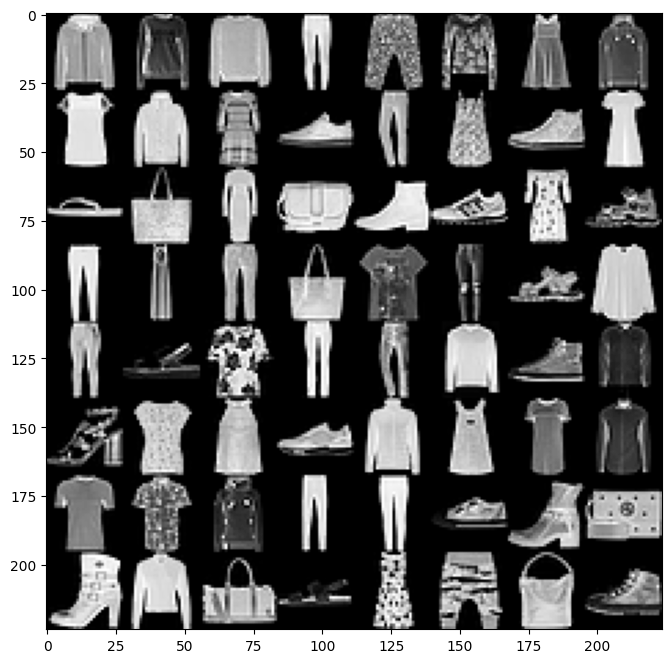

In [12]:
# Array for decoding the categories
label_names = np.array(['T-shirt/top',
                        'Trouser',
                        'Pullover',
                        'Dress',
                        'Coat',
                        'Sandal',
                        'Shirt',
                        'Sneaker',
                        'Bag',
                        'Ankle boot'])

# Get a single data batch of 64 images
sample_images, sample_labels = next(iter(trainloader))

# Plot the images in a 8x8 grid
plt.figure(figsize=(8, 8))
plt.imshow(
    sample_images.numpy().reshape(8, 8, 28, 28).transpose((0, 2, 1, 3)).reshape(224, 224),
    cmap='gray'
)
# Print corresponding labels
print(label_names[sample_labels.numpy().reshape(8, 8)])

**Task**:

Train a model which is an average of two models with different numbers of layers on the Fashion MNIST dataset, e.g.:

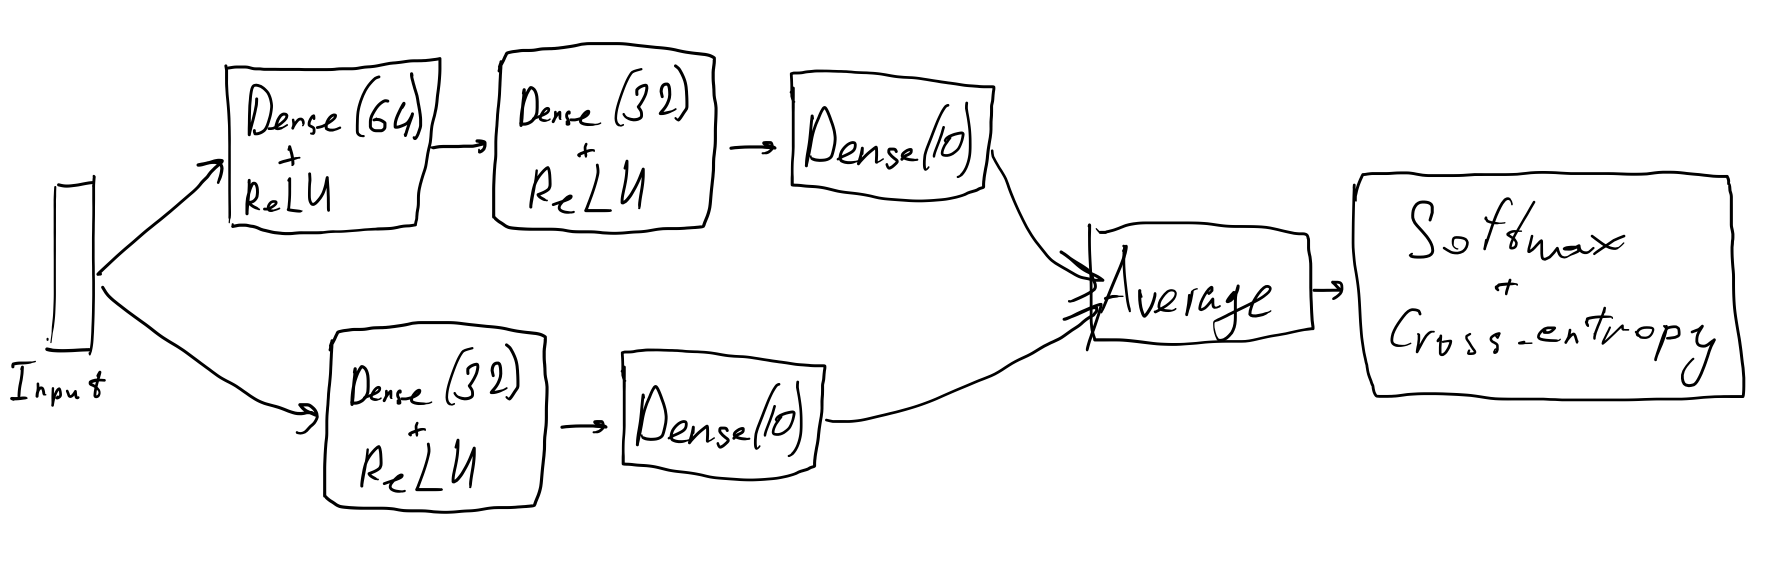

In [13]:
#<YOUR CODE>

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define two separate models
class ModelA(nn.Module):
    def __init__(self):
        super(ModelA, self).__init__()
        self.fc1 = nn.Linear(784, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class ModelB(nn.Module):
    def __init__(self):
        super(ModelB, self).__init__()
        self.fc1 = nn.Linear(784, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# Instantiate the models
model_a = ModelA()
model_b = ModelB()

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizers
optimizer_a = torch.optim.Adam(model_a.parameters())
optimizer_b = torch.optim.Adam(model_b.parameters())

# Prepare the data loaders
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.FashionMNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Training loop
epochs = 10
for epoch in range(epochs):
    for images, labels in trainloader:
        # Flatten Fashion-MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)

        # Zero the gradients
        optimizer_a.zero_grad()
        optimizer_b.zero_grad()

        # Forward pass for both models
        output_a = model_a(images)
        output_b = model_b(images)

        # Average the outputs
        average_output = (output_a + output_b) / 2

        # Calculate the loss
        loss = criterion(average_output, labels) # No need to apply softmax, as nn.CrossEntropyLoss does this internally

        # Backward pass for both models
        loss.backward()

        # Update the parameters for both models
        optimizer_a.step()
        optimizer_b.step()

    print(f'Epoch {epoch+1}/{epochs} - Loss: {loss.item()}')


Epoch 1/10 - Loss: 0.6623576879501343
Epoch 2/10 - Loss: 0.2732420563697815
Epoch 3/10 - Loss: 0.2234315276145935
Epoch 4/10 - Loss: 0.20235902070999146
Epoch 5/10 - Loss: 0.5406951308250427
Epoch 6/10 - Loss: 0.11879683285951614
Epoch 7/10 - Loss: 0.2077086716890335
Epoch 8/10 - Loss: 0.1716112345457077
Epoch 9/10 - Loss: 0.3382939398288727
Epoch 10/10 - Loss: 0.5414956212043762


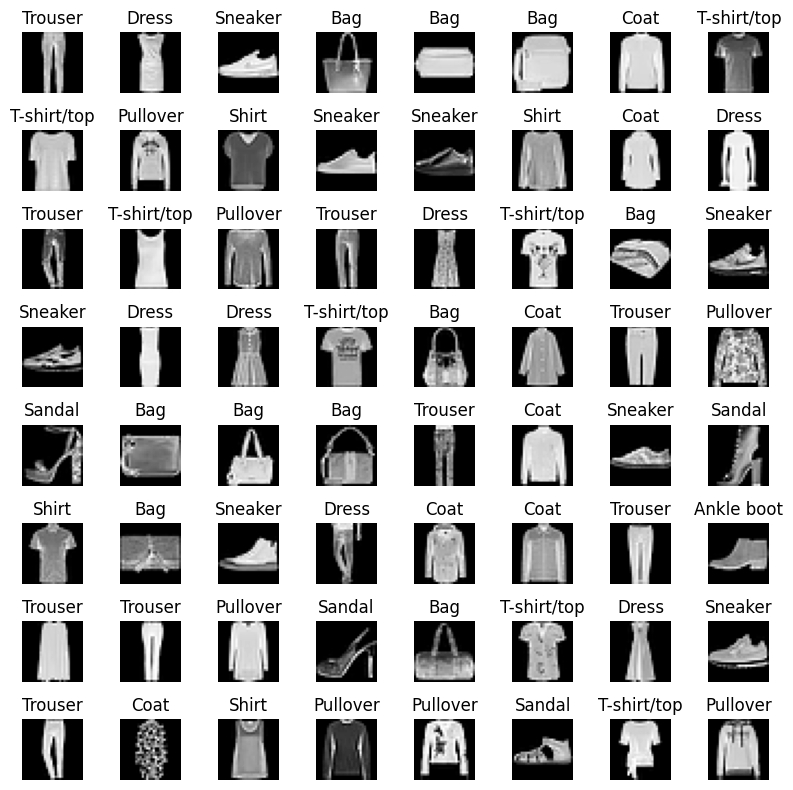

In [14]:

def get_predictions(output_a, output_b):
    # Average the outputs from the two models
    average_output = (output_a + output_b) / 2
    # Apply softmax to the averaged outputs to get probabilities
    probabilities = F.softmax(average_output, dim=1)
    # Get the predicted class from the probabilities
    _, predictions = torch.max(probabilities, 1)
    return predictions

sample_images, sample_labels = next(iter(trainloader))
sample_images_flattened = sample_images.view(sample_images.shape[0], -1)

output_a = model_a(sample_images_flattened)
output_b = model_b(sample_images_flattened)
predictions = get_predictions(output_a, output_b)
fig, axes = plt.subplots(8, 8, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(sample_images[i].numpy().squeeze(), cmap='gray')
    ax.set_title(label_names[predictions[i].item()])
    ax.axis('off')

plt.tight_layout()
plt.show()
